In [243]:
# Import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [244]:
# Read csv file as a dataframe and set header the top line
raw_ship_data = pd.read_csv('data.csv', index_col=0, header=0, parse_dates=True)

C:\Users\marin\AppData\Local\Temp\ipykernel_6940\73994996.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_ship_data = pd.read_csv('data.csv', index_col=0, header=0, parse_dates=True)


In [245]:
# Print the columns of our data
print(raw_ship_data.columns)

Index(['CallSign', 'ShipName', 'Type', 'ImoNumber', 'MMSI', 'latitude',
       'longitude', 'Destination', 'FixType', 'Dimension A', 'Dimension B',
       'Dimension C', 'Dimension D', 'MaximumStaticDraught', 'MessageID'],
      dtype='object')


In [246]:
# Get the shape of our dataframe
raw_ship_data.shape

(1003, 15)

In [247]:
# Dataframe unique values overview
raw_ship_data.nunique()

CallSign                 91
ShipName                 91
Type                     24
ImoNumber                76
MMSI                     92
latitude                752
longitude               742
Destination              44
FixType                   5
Dimension A              59
Dimension B              42
Dimension C              23
Dimension D              22
MaximumStaticDraught     49
MessageID                 1
dtype: int64

In [252]:
raw_ship_data['length'] = (raw_ship_data['Dimension A'] + raw_ship_data['Dimension B'])
raw_ship_data['width'] = (raw_ship_data['Dimension C'] + raw_ship_data['Dimension D'])
raw_ship_data = raw_ship_data.drop(columns=['Dimension A', 'Dimension B', 'Dimension C', 'Dimension D'])

In [259]:
length_dimension = raw_ship_data[(raw_ship_data['length']==0)]
width_dimension = raw_ship_data[(raw_ship_data['width']==0)]
print(length_dimension['Type'].unique())
print(width_dimension['Type'].unique())

[70 52  0]
[70 52  0]


70 = cargo,
52 = Tug,
0 = default,

In [279]:
# Get all the ships that are of type cargo, tug, default
cargo = raw_ship_data[(raw_ship_data['Type'] == 70)]
tug = raw_ship_data[(raw_ship_data['Type'] == 52)]
default = raw_ship_data[(raw_ship_data['Type'] == 0)]

In [283]:
# Calculate the mean value of their dimensions
cargo_mean_length = int(cargo['length'].mean())
cargo_mean_width = int(cargo['width'].mean())

tug_mean_length = int(tug['length'].mean())
tug_mean_width = int(tug['width'].mean())

default_mean_length = int(default['length'].mean())
default_mean_width = int(default['width'].mean())

In [284]:
# Replace the zero values with the mean value
raw_ship_data.loc[(raw_ship_data['length'] == 0) & (raw_ship_data['Type']==70), ['length']] = cargo_mean_length
raw_ship_data.loc[(raw_ship_data['width'] == 0) & (raw_ship_data['Type']==70), ['width']] = cargo_mean_width

raw_ship_data.loc[(raw_ship_data['length'] == 0) & (raw_ship_data['Type']==52), ['length']] = tug_mean_length
raw_ship_data.loc[(raw_ship_data['width'] == 0) & (raw_ship_data['Type']==52), ['width']] = tug_mean_width

raw_ship_data.loc[(raw_ship_data['length'] == 0) & (raw_ship_data['Type']==0), ['length']] = default_mean_length
raw_ship_data.loc[(raw_ship_data['length'] == 0) & (raw_ship_data['Type']==0), ['width']] = tug_mean_width

In [289]:
#raw_ship_data.loc[(raw_ship_data['width'] == 0) & (raw_ship_data['Type']==70)]
raw_ship_data = raw_ship_data
display(raw_ship_data)

,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,MaximumStaticDraught,MessageID,length,width
time_utc,,,,,,,,,,,,,
2023-12-09 08:05:51.944186364 +0000 UTC,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,4.5,5,135.0,30
2023-12-09 08:05:54.203014122 +0000 UTC,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,2.4,5,28.0,9
2023-12-09 08:05:57.546130448 +0000 UTC,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,10.0,5,158.0,24
2023-12-09 08:06:05.451479994 +0000 UTC,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,2.4,5,50.0,10
2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,0.0,5,175.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-09 09:39:23.429106768 +0000 UTC,V3OJ,HOLMA,33,7333327,312349000,34.645230,33.010070,HERZLIYA MARINA,1,3.0,5,40.0,9
2023-12-09 09:39:29.631362384 +0000 UTC,SVSV7,CHRISTOS LV,52,9371464,241776000,34.668703,33.052005,CYLMS,1,4.6,5,56.0,16
2023-12-09 09:39:29.747263668 +0000 UTC,6BBI,EGY CROWN,79,9216107,622113180,34.666713,33.078463,CYLMS ANCHORAGE AREA,0,9.5,5,140.0,50


In [287]:
# Find the number of unique ships inside of our table using as key the MMSI since it has no 0 values and it is an ID attribute
print(np.sort(raw_ship_data['MMSI'].unique()))

[  4282000 209005000 209166000 209343000 209352000 209492000 209511000
 209969000 210282000 210330000 210588000 210595000 211920000 212212000
 212230000 212319000 212541000 212717000 212858000 212872000 215013000
 215209000 229447000 233303000 235090927 236723000 241776000 244810178
 247274900 248823000 255806109 255977000 255979000 256060000 256081000
 256251000 257073920 271044343 271047045 271051041 271052043 305299000
 305384000 311000706 312349000 319222400 319234300 319287000 345050010
 352002159 352002364 352002749 353822000 371343000 375369000 428000112
 428000407 428007000 428009070 428045000 428066000 428068000 428990000
 470763000 511100389 511100460 511100504 511100835 518998397 538002973
 538003685 538007432 538009102 538009176 563112000 572705210 577171000
 613226010 613871403 622113180 630001049 636014902 636015074 636019201
 636021330 636021691 636022888 667001448 667001603 668116210 671290100
 987170323]


In [290]:
# Get a dataframe with only the single ships
unique_ships = raw_ship_data.drop_duplicates(subset=['MMSI'])
display(unique_ships)

,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,MaximumStaticDraught,MessageID,length,width
time_utc,,,,,,,,,,,,,
2023-12-09 08:05:51.944186364 +0000 UTC,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,4.5,5,135.0,30
2023-12-09 08:05:54.203014122 +0000 UTC,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,2.4,5,28.0,9
2023-12-09 08:05:57.546130448 +0000 UTC,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,10.0,5,158.0,24
2023-12-09 08:06:05.451479994 +0000 UTC,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,2.4,5,50.0,10
2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,0.0,5,175.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-09 09:09:12.122336029 +0000 UTC,V7SN2,DANCHOR IX,99,9316787,538003685,32.814877,35.030665,NaN,1,2.1,5,59.0,9
2023-12-09 09:09:29.41629581 +0000 UTC,3E3832,NOVA CORALIA,70,8918409,352002159,32.818160,35.016760,IL HFA,1,7.1,5,119.0,18
2023-12-09 09:09:38.548450027 +0000 UTC,5BWY5,LEDRA EXPLORER,52,0,210330000,34.541397,33.239995,LIMASSOL CYPRUS,0,3.0,5,39.0,9


In [291]:
# Find the different type of ships
ship_type = unique_ships['Type'].unique()
print(np.sort(ship_type))

[ 0 31 33 34 35 37 40 50 51 52 59 60 68 69 70 71 79 80 82 89 90 91 92 99]


 0  = default,
 31 = Towing,
 33 = Dredging,
 34 = Diving,
 35 = Military,
 37 = Pleasure,
 40 = HighSpeedCraft (HSC),
 50 = Pilot,
 51 = SAR,
 52 = Tug,
 59 = Noncombatant,
 60 = Passenger,
 68 = Passenger Reserved for future use,
 69 = Passenger No additional information,
 70 = Cargo all ships of this type,
 71 = Cargo Hazardous category A,
 79 = Cargo No additional information,
 80 = Tanker all ships of this type,
 82 = Tanker Hazardous category B,
 89 = Tanker No additional information,
 90 = Other Type all ships of this type,
 91 = Other Type Hazardous category A,
 92 = Other Type Hazardous category B,
 99 = Other Type no additional information

In [307]:
unique_ships.loc[(unique_ships['Type'] == 71) | (unique_ships['Type'] == 79)] = 70
unique_ships.loc[(unique_ships['Type'] == 68) | (unique_ships['Type'] == 69)] = 60
unique_ships.loc[(unique_ships['Type'] == 82) | (unique_ships['Type'] == 89)] = 80
unique_ships.loc[(unique_ships['Type'] == 91) | (unique_ships['Type'] == 92) | (unique_ships['Type'] == 99)] = 90


In [308]:
proportion = unique_ships['Type'].value_counts(normalize=True)

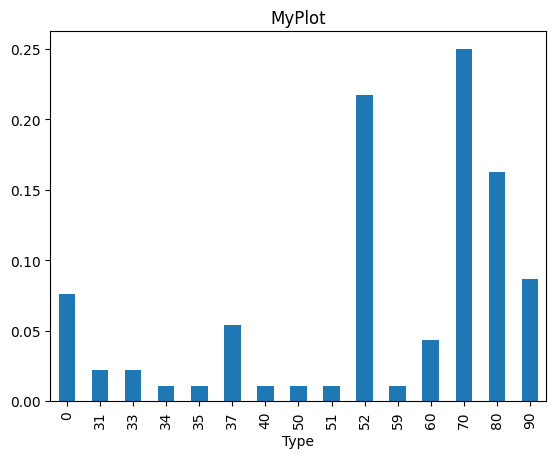

In [309]:
plot = proportion.sort_index().plot(kind='bar', title='MyPlot')

In [294]:
# Find the different fix types provided
fix_type = raw_ship_data['FixType'].unique()
print(fix_type)

[ 1  0 15  6  3]


0 = Default
1 = GPS
3 = GPS + GLONASS
6 = INS
15 = internal GNSS


In [295]:
#unique_ships = raw_ship_data[(raw_ship_data['MMSI'].unique())]
#print(unique_ships)